In [24]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [25]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('u_user.csv', sep='|', names=user_columns) 
users_df.head(2)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [26]:
genre_df = pd.read_csv("u_genre.csv", sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
print(genre_columns)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [27]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('u_item.csv', sep='|', names=movie_columns+genre_columns,
                     encoding='latin-1')
movies_df = movies_df[["movie_id", "title"]]
movies_df.head(2)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


In [28]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('u_data.csv', sep='\t', names=ratings_columns)
# ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
ratings_df

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [29]:
# Chia 80/20 theo thời gian của từng user_id
def split_train_test_by_user(df, user_col='user_id', time_col='unix_timestamp', train_ratio=0.8):
    train_list = []
    test_list = []

    # Lặp qua từng user
    for user_id, user_data in df.groupby(user_col):
        # Sắp xếp dữ liệu của user theo thời gian
        user_data = user_data.sort_values(by=time_col)
        
        # Xác định số lượng dòng thuộc train (80%) và test (20%)
        train_size = int(len(user_data) * train_ratio)
        
        # Chia dữ liệu
        train_list.append(user_data.iloc[:train_size])  # 80% đầu tiên
        test_list.append(user_data.iloc[train_size:])  # 20% cuối cùng

    # Kết hợp lại thành DataFrame
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)
    
    return train_df, test_df

# Gọi hàm chia dữ liệu
train_df, test_df = split_train_test_by_user(ratings_df, user_col='user_id', time_col='unix_timestamp')

train_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
test_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
test_df

,user_id,movie_id,rating
74847,1,116,3
10508,1,208,5
8976,1,12,5
5233,1,125,3
83307,1,3,4
...,...,...,...
81005,943,450,1
95003,943,230,1
95291,943,228,3
92536,943,227,1


In [30]:
rating_movies_df = train_df.merge(movies_df, how="outer")
print(rating_movies_df.shape)
rating_movies_df.head(2)

(79690, 4)


,user_id,movie_id,rating,title
0,1.0,1,5.0,Toy Story (1995)
1,2.0,1,4.0,Toy Story (1995)


In [31]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),5
1,1-900 (1994),4
2,101 Dalmatians (1996),75
3,12 Angry Men (1957),109
4,187 (1997),28


In [32]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")
rating_movies_df.head()

,user_id,movie_id,rating,title,total_rating_count
0,299.0,1300,2.0,'Til There Was You (1997),5
1,342.0,1300,1.0,'Til There Was You (1997),5
2,416.0,1300,3.0,'Til There Was You (1997),5
3,532.0,1300,3.0,'Til There Was You (1997),5
4,782.0,1300,2.0,'Til There Was You (1997),5


In [33]:
rating_movies_df.total_rating_count.describe()

count    79690.000000
mean       150.861112
std        112.657745
min          0.000000
25%         61.000000
50%        128.000000
75%        212.000000
max        514.000000
Name: total_rating_count, dtype: float64

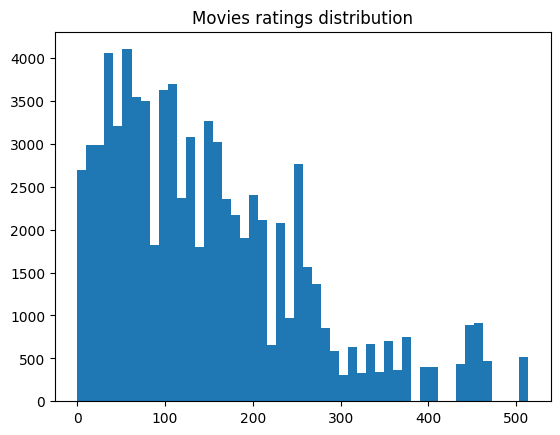

In [34]:
import matplotlib.pyplot as plt
plt.hist(rating_movies_df.total_rating_count, bins=50)
plt.title("Movies ratings distribution")
plt.show()

In [35]:
ratings_threshold = 100
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.head()

(48557, 5)


,user_id,movie_id,rating,title,total_rating_count
84,6.0,178,4.0,12 Angry Men (1957),109
85,7.0,178,4.0,12 Angry Men (1957),109
86,10.0,178,5.0,12 Angry Men (1957),109
87,13.0,178,4.0,12 Angry Men (1957),109
88,16.0,178,5.0,12 Angry Men (1957),109


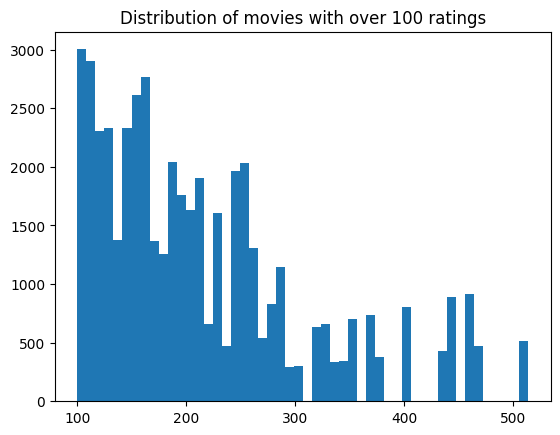

In [36]:
plt.hist(rating_popular_movies_df.total_rating_count, bins=50)
plt.title("Distribution of movies with over 100 ratings")
plt.show()

In [37]:
user_features_df = rating_popular_movies_df.pivot_table(index="user_id", columns="title", values="rating").fillna(0.0)

In [38]:
user_features_matrix = csr_matrix(user_features_df)

In [39]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute", n_neighbors = 20, n_jobs=-1)
model_knn.fit(user_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [40]:
user_features_df.shape

(943, 268)

In [41]:
user_features_df.head()

title,12 Angry Men (1957),2001: A Space Odyssey (1968),"Abyss, The (1989)","African Queen, The (1951)",Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amadeus (1984),"American President, The (1995)",...,Unforgiven (1992),"Usual Suspects, The (1995)",Vertigo (1958),Volcano (1997),Wag the Dog (1997),When Harry Met Sally... (1989),While You Were Sleeping (1995),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)",Young Frankenstein (1974)
user_id,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,4.0,3.0,0.0,0.0,4.0,5.0,5.0,5.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,4.0,0.0,0.0,0.0,4.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,4.0


In [42]:
query_index = np.random.choice(user_features_df.shape[0])
print(query_index)

713


In [43]:
distances, indices = model_knn.kneighbors(user_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [44]:
def recommend_with_similarity_weight(user_id=10, n_users=10, rec_top_n=20, min_rating=3.5):
    """
    Gợi ý phim dựa trên trọng số độ tương đồng giữa người dùng.
    """
    # Tìm n người dùng tương đồng nhất với user_id
    distances, indices = model_knn.kneighbors(
        user_features_df.loc[user_features_df.index == user_id].values.reshape(1, -1),
        n_neighbors=n_users + 1  # +1 để bao gồm cả người dùng hiện tại
    )

    # Lấy danh sách user_id và độ tương đồng tương ứng (bỏ người dùng hiện tại)
    user_ids = [user_features_df.index[indices.flatten()[i]] for i in range(1, n_users + 1)]
    similarities = 1 - distances.flatten()[1:]  # Độ tương đồng (1 - khoảng cách)

    # Lấy các đánh giá của người dùng tương đồng và lọc ra những phim có rating > min_rating
    sel_ratings = rating_popular_movies_df.loc[
        rating_popular_movies_df.user_id.isin(user_ids) & (rating_popular_movies_df.rating > min_rating)
    ]

    # Loại bỏ các phim đã được người dùng hiện tại xem
    movies_rated_by_targeted_user = rating_popular_movies_df.loc[
        rating_popular_movies_df.user_id == user_id, "movie_id"
    ].values
    sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]

    # Tính avg score (trung bình có trọng số theo similarity) cho mỗi phim
    movie_scores = {}
    for movie_id in sel_ratings["movie_id"].unique():
        ratings_for_movie = sel_ratings[sel_ratings.movie_id == movie_id]

        # Tính tổng trọng số (numerator) và tổng similarity (denominator)
        numerator = 0
        denominator = 0
        for _, row in ratings_for_movie.iterrows():
            user_index = user_ids.index(row["user_id"])  # Vị trí người dùng trong danh sách
            sim = similarities[user_index]  # Độ tương đồng với người dùng hiện tại
            numerator += sim * row["rating"]
            denominator += sim

        # Tính avg score cho phim này
        movie_scores[int(movie_id)] = numerator / denominator if denominator != 0 else 0

    # Tính viewer score chuẩn hóa theo similarity (thang điểm 5)
    movie_priority = sel_ratings.groupby("movie_id").agg(
        viewers=("user_id", "nunique")  # Số lượng người dùng đã xem
    ).reset_index()
    movie_priority["viewer_score"] = (
        movie_priority["viewers"] / max(movie_priority["viewers"]) * 5
    )

    # Kết hợp avg score và viewer score để tính final score
    movie_priority["avg_score"] = movie_priority["movie_id"].map(movie_scores)
    movie_priority["final_score"] = (
        movie_priority["viewer_score"] * 0.51 + movie_priority["avg_score"] * 0.49
    )

    # Sắp xếp theo final_score giảm dần và lấy top n phim
    top_movies = movie_priority.sort_values(by="final_score", ascending=False).head(rec_top_n)

    # Trả ra danh sách list con chứa [movie_id, final_score]
    recommended_movie_ids = [[int(row.movie_id), row.final_score] for _, row in top_movies.iterrows()]
    return recommended_movie_ids

# Gọi hàm và in ra kết quả
recommended_ids = recommend_with_similarity_weight(user_id=12, n_users=10, rec_top_n=20)
print(recommended_ids)


[[64, 4.903959264312485], [318, 4.744999999999999], [181, 4.587529426626656], [95, 4.31392069718168], [735, 4.304283788591798], [216, 4.3026145758229735], [56, 4.301390025528553], [237, 4.255], [12, 4.249135844750557], [173, 4.235], [79, 4.160255460500869], [204, 4.123669234839075], [183, 4.11726123456109], [97, 4.092528013033965], [1, 4.090013823689997], [423, 4.086749069856294], [22, 4.026655673191913], [11, 4.026160710051813], [176, 4.019249964290167], [144, 4.01900439960618]]


In [45]:
recommended_movies = recommend_with_similarity_weight(
    user_id=10, n_users=6, rec_top_n=10, min_rating=3
)
recommended_movie_ids = [movie[0] for movie in recommended_movies]  # Lấy danh sách movie_id
recommended_movie_ids

[427, 89, 238, 209, 183, 187, 173, 432, 523, 504]

In [54]:
user_id = 106
recommended_movies = recommend_with_similarity_weight(
    user_id=user_id, n_users=6, rec_top_n=10, min_rating=3
)
recommended_movie_ids = [movie[0] for movie in recommended_movies]  # Lấy danh sách movie_id
recommended_movie_ids
# Lấy danh sách phim thực tế có rating cao trong tập test
actual_movies = test_df.loc[
    (test_df['user_id'] == user_id) & (test_df['rating'] >= 3.0), 'movie_id'
].values
actual_movies
# Tính số lượng phim được gợi ý đúng
relevant_movies = set(recommended_movie_ids) & set(actual_movies)  # Giao giữa 2 danh sách
num_relevant = len(relevant_movies)

# Precision@K
precision_at_k = num_relevant / 10

# Recall@K
recall_at_k = num_relevant / len(actual_movies) if len(actual_movies) > 0 else 0
# Tính HR (Hit Ratio)
hit_ratio = 1 if len(relevant_movies) > 0 else 0

# Tính F1-Score
if precision_at_k + recall_at_k > 0:
    f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
else:
    f1_score = 0

# In kết quả
print(f"Hit Ratio (HR): {hit_ratio}")
print(f"F1-Score: {f1_score:.4f}")

# In kết quả
print(f"Precision@K: {precision_at_k:.4f}")
print(f"Recall@K: {recall_at_k:.4f}")


Hit Ratio (HR): 1
F1-Score: 0.1905
Precision@K: 0.2000
Recall@K: 0.1818


In [55]:
def calculate_metrics(test_df, recommend_with_similarity_weight, n_users=6, rec_top_n=10, min_rating=3):
    all_precision_at_k = []
    all_recall_at_k = []
    all_hit_ratios = []
    all_f1_scores = []

    unique_users = test_df['user_id'].unique()  # Lấy danh sách user_id

    for user_id in unique_users:
        # Gợi ý phim cho người dùng
        recommended_movies = recommend_with_similarity_weight(
            user_id=user_id, n_users=n_users, rec_top_n=rec_top_n, min_rating=min_rating
        )
        recommended_movie_ids = [movie[0] for movie in recommended_movies]

        # Lấy danh sách phim thực tế có rating cao trong tập test
        actual_movies = test_df.loc[
            (test_df['user_id'] == user_id) & (test_df['rating'] >= min_rating), 'movie_id'
        ].values

        # Tính số lượng phim được gợi ý đúng
        relevant_movies = set(recommended_movie_ids) & set(actual_movies)
        num_relevant = len(relevant_movies)

        # Precision@K
        precision_at_k = num_relevant / rec_top_n

        # Recall@K
        recall_at_k = num_relevant / len(actual_movies) if len(actual_movies) > 0 else 0

        # Hit Ratio
        hit_ratio = 1 if len(relevant_movies) > 0 else 0

        # F1-Score
        if precision_at_k + recall_at_k > 0:
            f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
        else:
            f1_score = 0

        # Lưu kết quả
        all_precision_at_k.append(precision_at_k)
        all_recall_at_k.append(recall_at_k)
        all_hit_ratios.append(hit_ratio)
        all_f1_scores.append(f1_score)

    # Tính trung bình
    avg_precision_at_k = sum(all_precision_at_k) / len(all_precision_at_k)
    avg_recall_at_k = sum(all_recall_at_k) / len(all_recall_at_k)
    avg_hit_ratio = sum(all_hit_ratios) / len(all_hit_ratios)
    avg_f1_score = sum(all_f1_scores) / len(all_f1_scores)

    # Trả về kết quả
    return {
        "Average Precision@K": avg_precision_at_k,
        "Average Recall@K": avg_recall_at_k,
        "Average Hit Ratio": avg_hit_ratio,
        "Average F1-Score": avg_f1_score
    }


In [58]:
# Giả sử test_df là DataFrame chứa tập test và hàm recommend_with_similarity_weight đã được định nghĩa
metrics = calculate_metrics(test_df, recommend_with_similarity_weight, n_users=6, rec_top_n=20, min_rating=3)
print(metrics)

{'Average Precision@K': 0.10546129374337183, 'Average Recall@K': 0.16191351520076663, 'Average Hit Ratio': 0.7094379639448568, 'Average F1-Score': 0.10806139709195699}


In [60]:
# Gọi hàm tính Precision@K và Recall@K trung bình
precision_avg, recall_avg = average_precision_recall_at_k(test_df, train_df, k=6, min_rating=3.0)

# In kết quả
print(f"Precision@K (Trung bình): {precision_avg:.4f}")
print(f"Recall@K (Trung bình): {recall_avg:.4f}")

Precision@K (Trung bình): 0.1468
Recall@K (Trung bình): 0.0724


In [53]:
user_train_data = test_df[test_df['user_id'] == 12]
user_train_data

,user_id,movie_id,rating
7852,12,191,5
34224,12,216,5
44328,12,4,5
6080,12,97,5
13269,12,402,5
5425,12,735,5
77328,12,88,5
77657,12,238,5
29110,12,242,5
19337,12,318,5
